<h1 style="text-align: center; margin-left:50px;">Duck hunt remake</h1>
<hr>
<div style="text-align: center">Nenad Mišić</div>
<div style="text-align: center">SW-31/2016</div>
<div style="text-align: center">Fakultet Tehničkih Nauka, Novi Sad</div>
<hr>

### Imports

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint

from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN

import os
import math
import random
from datetime import datetime
import argparse

import pickle

Using TensorFlow backend.


### Constants

In [5]:
BIG_WIDTH = 1600
BIG_HEIGHT = 1200
SMALL_WIDTH = 400
SMALL_HEIGHT = 300

DISPLAY_CROP_WIDTH = 750
DISPLAY_CROP_HEIGHT = 500

WIDTH_RATIO = BIG_WIDTH / SMALL_WIDTH
HEIGHT_RATIO = BIG_HEIGHT / SMALL_HEIGHT

APPROX_DISPLAY_WIDTH_ON_SMALL = 125
APPROX_DISPLAY_HEIGHT_ON_SMALL = 80

COLOR_GREEN = (35,255,12)
COLOR_RED = (255,0,0)

### Simple functions

In [81]:
def load_image(path):
    #loads image and converts it to RGB
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def load_gray_image(path):
    #loads image and converts it to grayscale
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
def display_image(image):
    #shows RGB image
    plt.imshow(image)
def display_gray_image(image):
    #shows grayscaled image
    plt.imshow(image, 'gray')
def resize_image(image, width, height):
    #resizes image to height * width
    return cv2.resize(image, (width,height))
def blur_image(image):
    return cv2.GaussianBlur(image, (5,5), 0)
def do_canny(image, parameter1=30, parameter2=130):
    return cv2.Canny(blur_image(image), parameter1, parameter2, 1)
def predict_image(classificator, image):
    return classificator.predict(reshape_data(np.array([hog.compute(image)])))
def cnn_predict_image(model, image):
    image = img_to_array(blur_image(image))
    image = np.expand_dims(image, axis=0)
    images = np.vstack([image])
    predictions = model.predict_classes(images, batch_size=1)
    return predictions[0]
    #I inverted the labels :)
    #return 1 if predictions[0]==0 else 1
def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))

def doRectanglesOverlap(lu1, rd1, lu2, rd2): 
    if(lu1[0] > rd2[0] or lu2[0] > rd1[0]): 
        return False
    if(-lu1[1] < -rd2[1] or -lu2[1] < -rd1[1]): 
        return False
    return True

### Advanced functions

#### Display exctraction

In [31]:
#expects grayscale image containing display
#returns tuple (croppedImage,crosshairCoordinates)
def crop_the_display_out_of_image(image):
    #scale the image down to remove the noise as we are only detecting display
    image_small = resize_image(image, SMALL_WIDTH, SMALL_HEIGHT)
    
    #find threshold for canny edge detector using OTSU method
    high_thresh, thresh_im = cv2.threshold(image_small, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
    
    #apply canny edge detector to given image
    canny = do_canny(image_small, low_thresh,high_thresh)

    #zero out the borders
    borderLen = 5
    lenx, leny = canny.shape

    canny[0:borderLen,0:leny] = 0
    canny[lenx-borderLen:lenx,0:leny] = 0
    canny[0:lenx,0:borderLen] = 0
    canny[0:lenx,leny-borderLen:leny] = 0

    #find contours from image returned by canny edge detector
    contours = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    potential_contours = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        #check if contour is potential for display
        if(w > APPROX_DISPLAY_WIDTH_ON_SMALL and h > APPROX_DISPLAY_HEIGHT_ON_SMALL):
            potential_contours.append([x,y,w,h])

    if(len(potential_contours) == 1):
        #we probably found the display contour
        x,y,w,h = potential_contours[0]
        
        #scale parameters up because canny is applied to reduced image
        xd, yd, wd, hd = int(WIDTH_RATIO*x), int(HEIGHT_RATIO*y), int(WIDTH_RATIO*w), int(HEIGHT_RATIO*h)
        
        #find central pixel on image
        central = (int(image.shape[1]/2), int(image.shape[0]/2))

        #crop the display out of the image
        crop_img = image[yd:yd+hd, xd:xd+wd]
        #find the coordinates of central pixel on display
        cropped_central = (int(central[0]-xd), int(central[1]-yd))
        
        return crop_img, cropped_central
    else:
        #we found more than 1 potential contour
        #log the value, so we know how to debug it :)
        print(len(potential_contours))

### Dataset preparation

#### Dataset location

In [8]:
DATASET_LOCATION = "Datasets/Dataset-game"

#### Grayscale and resize

In [9]:
def grayscale_and_resize():
    prep_dir = DATASET_LOCATION + 'Ducks_unprocessed/'
    finish_dir = DATASET_LOCATION + 'Ducks_processed/'

    for img_name in os.listdir(prep_dir):
        img_path = os.path.join(prep_dir, img_name)
        img_path_save = os.path.join(finish_dir, img_name)

        #load and grayscale images from unprocessed folder
        img = load_gray_image(img_path)
        #save resized images in processed folder
        cv2.imwrite(img_path_save, resize_image(img, BIG_WIDTH, BIG_HEIGHT)) 

#### Crop the display

In [10]:
def crop_the_display():
    prep_dir = DATASET_LOCATION + 'Ducks_processed/'
    finish_dir = DATASET_LOCATION + 'Ducks_processed_crop/'
    
    for img_name in os.listdir(prep_dir):
        img_path = os.path.join(prep_dir, img_name)
        img_path_save = os.path.join(finish_dir, img_name)
        
        #load and grayscale images from processed folder
        image = load_gray_image(img_path)
        
        #blur the image
        blurred = blur_image(image)
        
        #crop the display out of image
        cropAndCentral = crop_the_display_out_of_image(blurred)
        if cropAndCentral is None:
            print(img_name)
        else:
            crop_image, central = cropAndCentral
        #save cropped image in processed_crop folder
        cv2.imwrite(img_path_save, resize_image(crop_image,DISPLAY_CROP_WIDTH,DISPLAY_CROP_HEIGHT)) 

#### Divide display into 15x10 matrix

In [11]:
def image_to_matrix():
    prep_dir = DATASET_LOCATION + 'Ducks_processed_crop/'
    finish_dir_bird = DATASET_LOCATION + 'Ducks_processed_label_maybebird/'
    finish_dir_nobird = DATASET_LOCATION + 'Ducks_processed_label_defnotbird/'
    
    roi_file1 = open(DATASET_LOCATION + 'ducks_processed_roi1.txt', 'r')
    roi_file2 = open(DATASET_LOCATION + 'ducks_processed_roi2.txt', 'r')
    images_roi1 = {}
    images_roi2 = {}
    
    for line in roi_file1:
        img_name, a, b, c, d = line.split(',')
        images_roi1[img_name] = [a,b,c,d]
        
    for line in roi_file2:
        img_name, a, b, c, d = line.split(',')
        images_roi2[img_name] = [a,b,c,d]
        
    for img_name in os.listdir(prep_dir):
        img_path = os.path.join(prep_dir, img_name)
        image = load_gray_image(img_path)
        
        #this should be DISPLAY_CROP_HEIGHT,DISPLAY_CROP_WIDTH (500,750)
        h,w = image.shape
        
        #this should be 50,50
        cell_h, cell_w = math.floor(h/10), math.floor(w/15)
        
        #this should be 9
        num_of_rows = math.floor(h/cell_h)-1
        
        #this should be 14
        num_of_columns = math.floor(w/cell_w)-1 

        
        for i in range(num_of_rows):
            for j in range(num_of_columns):
                a_up = i*cell_h
                a_down = (i+2)*cell_h
                a_left = j*cell_w
                a_right = (j+2)*cell_w
                
                b = images_roi1[img_name]
                b_up = int(b[0])
                b_down = int(b[1])
                b_left = int(b[2])
                b_right = int(b[3])
                
                c = images_roi2[img_name]
                c_up = int(c[0])
                c_down = int(c[1])
                c_left = int(c[2])
                c_right = int(c[3])
                
                
                #save all 2x2 blocks into processed_label folder (later used for labeling and training)
                
                if doRectanglesOverlap((a_left, a_up), (a_right, a_down), (b_left, b_up), (b_right, b_down)):
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h: (i+2)*cell_h, j*cell_w: (j+2)*cell_w])
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_1" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h+2: (i+2)*cell_h+2, j*cell_w: (j+2)*cell_w])
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_2" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h-2: (i+2)*cell_h-2, j*cell_w: (j+2)*cell_w])
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_3" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h: (i+2)*cell_h, j*cell_w+2: (j+2)*cell_w+2])
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_4" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h: (i+2)*cell_h, j*cell_w-2: (j+2)*cell_w-2])
                elif doRectanglesOverlap((a_left, a_up), (a_right, a_down), (c_left, c_up), (c_right, c_down)):
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h: (i+2)*cell_h, j*cell_w: (j+2)*cell_w])
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_1" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h+2: (i+2)*cell_h+2, j*cell_w: (j+2)*cell_w])
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_2" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h-2: (i+2)*cell_h-2, j*cell_w: (j+2)*cell_w])
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_3" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h: (i+2)*cell_h, j*cell_w+2: (j+2)*cell_w+2])
                    img_path_save = os.path.join(finish_dir_bird, str(i*math.floor(w/cell_w)+j) + "_4" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h: (i+2)*cell_h, j*cell_w-2: (j+2)*cell_w-2])
                else:
                    img_path_save = os.path.join(finish_dir_nobird, str(i*math.floor(w/cell_w)+j) + "_" + img_name)
                    cv2.imwrite(img_path_save, image[i*cell_h: (i+2)*cell_h, j*cell_w: (j+2)*cell_w])
                

#### Take labeled images and put them in one folder

In [12]:
def reshape_labeled_images():
    bird_dir = DATASET_LOCATION + 'Ducks_processed_label_bird/'
    notbird_dir = DATASET_LOCATION + 'Ducks_processed_label_notbird/'
    all_dir = DATASET_LOCATION + 'Ducks_processed_label_all/'
    
    for img_name in os.listdir(notbird_dir):
        img_path = os.path.join(notbird_dir, img_name)
        img_path_save = os.path.join(all_dir, "neg_" + img_name)
        image = load_gray_image(img_path)
        cv2.imwrite(img_path_save, image)
    for img_name in os.listdir(bird_dir):
        img_path = os.path.join(bird_dir, img_name)
        img_path_save = os.path.join(all_dir, "pos_" + img_name)
        image = load_gray_image(img_path)
        cv2.imwrite(img_path_save, image)

### Classifier training

#### Reading positive and negative images

In [13]:
#returns tuple (positiveImagesList, negativeImagesList)
def read_pos_and_neg_images():
    train_dir = DATASET_LOCATION + 'Ducks_processed_label_all/'

    pos_imgs = []
    neg_imgs = []

    for img_name in os.listdir(train_dir):
        img_path = os.path.join(train_dir, img_name)
        img = load_image(img_path)
        if 'pos' in img_name:
            pos_imgs.append(resize_image(img,100,100))
        elif 'neg' in img_name:
            neg_imgs.append(resize_image(img,100,100))

    #we assume that we have more negative images than positive
    #we make them even by getting sample of negative images size of positive images length
    neg_imgs = random.sample(neg_imgs, len(pos_imgs))
    
    return pos_imgs, neg_imgs

#### Function for training the HOG feature extractor

In [14]:
#expects two parameters, lists of positive and negative images
#returns tuple (numpy.vstack containing positive and negative features, numpy.array containing labels) 
def train_hog(pos_imgs, neg_imgs):
    pos_features = []
    neg_features = []
    labels = []

    nbins = 9 
    cell_size = (8, 8)
    block_size = (3, 3)

    hog = cv2.HOGDescriptor(_winSize=(100 // cell_size[1] * cell_size[1], 
                                      100 // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    for img in pos_imgs:
        pos_features.append(hog.compute(img))
        labels.append(1)

    for img in neg_imgs:
        neg_features.append(hog.compute(img))
        labels.append(0)

    pos_features = np.array(pos_features)
    neg_features = np.array(neg_features)
    x = np.vstack((pos_features, neg_features))
    y = np.array(labels)
    
    return x, y

<h1>Data preparation</h1>
    <h5 style="color:#FF6666">Skip if you have already done it...</h5>


In [28]:
grayscale_and_resize()

In [41]:
crop_the_display()

You should select roi now...

In [81]:
image_to_matrix()

You should label the images now...

In [82]:
reshape_labeled_images()

# Training the KNN and SVM classifiers

## Training HOG

In [12]:
pos_imgs, neg_imgs = read_pos_and_neg_images()
x, y = train_hog(pos_imgs, neg_imgs)

#split the dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#reshape them for sklearn
x_train = reshape_data(x_train)
x_test = reshape_data(x_test)

## KNN classifier

### Training the KNN
<h6 style="color:#FF6666">(may take few minutes)</h6>

In [13]:
#initialize KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=10)

#train the classifier using HOG features
clf_knn = clf_knn.fit(x_train, y_train)

#predict train and test data to extract accuracy
y_train_pred = clf_knn.predict(x_train)
y_test_pred = clf_knn.predict(x_test)

#print train and test accuracy
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

#save the classifier
pickle.dump(clf_knn, open("clf_knn.pickle", 'wb'))

Train accuracy:  0.823498139287613
Validation accuracy:  0.7727272727272727


### Loading already trained KNN

In [ ]:
clf_knn = pickle.load(open("clf_knn.pickle", 'rb'))

## SVM classifier

### Training the SVM
<h6 style="color:#FF6666">(may take few minutes)</h6>

In [84]:
#initialize SVM classifier
clf_svm = SVC(kernel='linear', probability=True) 

#train the classifier using HOG features
clf_svm.fit(x_train, y_train)

#predict train and test data to extract accuracy
y_train_pred = clf_svm.predict(x_train)
y_test_pred = clf_svm.predict(x_test)

#print train and test accuracy
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

#save the classifier
pickle.dump(clf_svm, open("clf_svm.pickle", 'wb'))

Train accuracy:  0.9992025518341308
Validation accuracy:  0.9354066985645934


### Loading already trained SVM

In [ ]:
clf_svm = pickle.load(open("clf_svm.pickle", 'rb'))

# Training the CNN classifier

## Architecture setup

In [15]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(100,100,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # the model so far outputs 3D feature maps (height, width, features)

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

## Training the CNN
<h5 style="color:#FF6666">may take few hours :) </h5>

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import matplotlib
matplotlib.use("Agg")

num_epochs = 5
batch_size = 32
model = create_model()

checkpointer = ModelCheckpoint(filepath="best_weights_cnn.hdf5", verbose=1, save_best_only=True)

start = datetime.now()

images = []
labels = []
pdir = DATASET_LOCATION + 'Ducks_processed_label_bird/'
ndir = DATASET_LOCATION + 'Ducks_processed_label_notbird/'

for img_name in os.listdir(pdir):
    img_path = os.path.join(pdir, img_name)
    img = load_gray_image(img_path)
    label = 0
    images.append(img_to_array(img))
    labels.append(label)
    
for img_name in random.sample(os.listdir(ndir), len(os.listdir(pdir))):
    img_path = os.path.join(ndir, img_name)
    img = load_gray_image(img_path)
    label = 1
    images.append(img_to_array(img))
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(images,labels, test_size=0.2, random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)
aug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")


H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
                        epochs=num_epochs,callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in: ", duration)

Epoch 1/5
104/104 [==============================] - 25s 240ms/step - loss: 1.6117 - accuracy: 0.5159 - val_loss: 0.6133 - val_accuracy: 0.6160

Epoch 00001: val_loss improved from inf to 0.61333, saving model to best_weights_cnn2.hdf5
Epoch 2/5
104/104 [==============================] - 25s 245ms/step - loss: 0.7030 - accuracy: 0.5723 - val_loss: 0.6031 - val_accuracy: 0.6561

Epoch 00002: val_loss improved from 0.61333 to 0.60308, saving model to best_weights_cnn2.hdf5
Epoch 3/5
104/104 [==============================] - 27s 255ms/step - loss: 0.7140 - accuracy: 0.6745 - val_loss: 0.4885 - val_accuracy: 0.8577

Epoch 00003: val_loss improved from 0.60308 to 0.48854, saving model to best_weights_cnn2.hdf5
Epoch 4/5
104/104 [==============================] - 26s 253ms/step - loss: 0.5989 - accuracy: 0.7366 - val_loss: 0.4694 - val_accuracy: 0.8457

Epoch 00004: val_loss improved from 0.48854 to 0.46943, saving model to best_weights_cnn2.hdf5
Epoch 5/5
104/104 [=========================

## Loading already trained CNN

In [71]:
model = create_model()
model.load_weights("best_weights_cnn.hdf5")


In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 64)       

# Predicting the given image

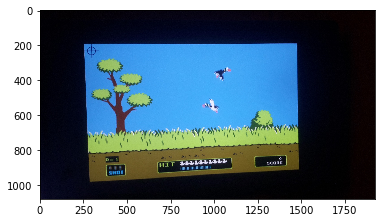

In [62]:
image = load_image(DATASET_LOCATION + 'testImage.jpg')
display_image(image)

Image predicted as bird. Time taken for classification: 0.062456seconds.


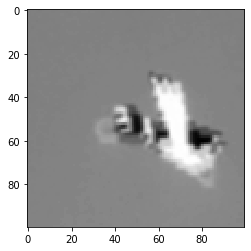

In [86]:
start = datetime.now()

grayscale_image = load_gray_image(DATASET_LOCATION + 'testImage.jpg')
resized_image = resize_image(grayscale_image, BIG_WIDTH, BIG_HEIGHT)
blurred = blur_image(resized_image)
crop_image, central = crop_the_display_out_of_image(blurred)
crop_image_resize = resize_image(crop_image,DISPLAY_CROP_WIDTH,DISPLAY_CROP_HEIGHT)
resize_ratio_width = DISPLAY_CROP_WIDTH / crop_image.shape[1]
resize_ratio_height = DISPLAY_CROP_HEIGHT / crop_image.shape[0]
central_resized = (int(central[0] * resize_ratio_width), int(central[1] * resize_ratio_height))

shooting_rectangle = crop_image_resize[central_resized[1] - 50: central_resized[1] + 50 ,central_resized[0] - 50 : central_resized[0] + 50]
display_gray_image(shooting_rectangle)

prediction = cnn_predict_image(model, shooting_rectangle)

duration = datetime.now() - start

print("Image predicted as " + ('bird' if prediction==0 else 'not bird') + ". Time taken for classification: " + str(duration.total_seconds()) + "seconds.")
    